# Trees and an intro to ensembles

1. After reg, and logit, **our "last" base model is** [**Trees**](https://scikit-learn.org/stable/modules/tree.html), which are great for [exploiting interactions between variables](https://dachxiu.chicagobooth.edu/download/ML.pdf)
1. [Ensembles, via `sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble): Supercharging your models
    - _Averaging methods:_ Bagging, forests of trees
    - _Boosting methods:_ **Gradient Boosting**
    - _Stacking:_ combining several distinct estimators

The main drawback with ensembles is usually interpretation and imbalanced classification.


## Trees - part 1

![](https://i.imgur.com/UUijyoa.gif)

## Trees

https://scikit-learn.org/stable/modules/tree.html#tree

| Pros | Cons | 
| :--- | :--- | 
| Simple, can visualize | Easy to overfit (thus: stopping decision) | 
| Little data prep | Unstable/inconsistent (thus: ensemble) |
| Somewhat robust to assumptions about data generating process | Doesn't estimate smooth relationships | 
| | Bad with imbalanced data (thus: balance before fitting) | 

In [20]:
# import lots of functions
import pandas as pd
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from df_after_transform import df_after_transform
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix


In [3]:
# load data 
loans = pd.read_csv('lendingclub/2013_subsample.zip')


In [4]:
# split to test and train (link to split page/sk docs)

# first let's separate y from X
y = loans.loan_status == 'Charged Off'
y.value_counts()
loans = loans.drop('loan_status',axis=1)

# stratify will make sure that test/train both have equal fractions of outcome
X_train, X_test, y_train, y_test = train_test_split(loans, y, stratify=y, test_size=.2, random_state=0)


In [5]:
## optimize a series of models 

# set up pipeline to clean each type of variable (1 pipe per var type)

numer_pipe = make_pipeline(SimpleImputer(),StandardScaler()) 
cat_pipe   = make_pipeline(OneHotEncoder(drop='first'))

# combine those pipes into "preprocess" pipe

preproc_pipe = ColumnTransformer(  
    [ # arg 1 of ColumnTransformer is a list, so this starts the list
    # a tuple for the numerical vars: name, pipe, which vars to apply to
    ("num_impute", numer_pipe, ['annual_inc']),
    # a tuple for the categorical vars: name, pipe, which vars to apply to
    ("cat_trans", cat_pipe, ['grade'])
    ]
    , remainder = 'drop' # you either drop or passthrough any vars not modified above
)

Setting up a tree estimator is the same as anything else!
1. Import estimator
2. Put into pipeline. Now you're ready to fit or use in CV

I've imported the Lending Club data from the prior lecture. 

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = make_pipeline(preproc_pipe, DecisionTreeClassifier())
tree_clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_impute',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['annual_inc']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['grade'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

You can plot a tree: `tree.plot_tree(<tree object>)`

But it's messy and huge on a complicated model like this so I won't show it:

In [ ]:
# from sklearn import tree # has the plotting function
# tree.plot_tree(tree_clf['decisiontreeclassifier']) 

This lending club example is a "classification" problem. A common output is a **"confusion matrix"**.

Let's look at these 3 versions... what do we learn?

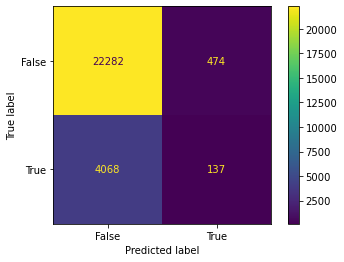

In [26]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree_clf, X_test, y_test, normalize=None) # normalize='all' {'true', 'pred', 'all'}
plt.show()

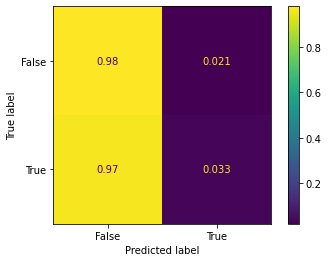

In [27]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree_clf, X_test, y_test, normalize='true') # normalize='all' {'true', 'pred', 'all'}
plt.show()

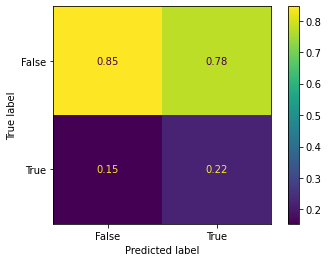

In [28]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree_clf, X_test, y_test, normalize='pred') # normalize='all' {'true', 'pred', 'all'}
plt.show()

In [10]:
# can use this in CV like before, and optimization

scores = cross_validate(tree_clf,X_train,y_train,scoring='precision_micro',
               cv=10)
scores['test_score'].mean()  # logit got us 0.84

0.8317275804124039

## Bagging

Rerunning the estimator (can be anything basically, here, I "bag a tree") on random samples of the training data, where samples are drawn with replacement. Each sub estimator gets equal weight. The idea is that by combining many estimators, we reduce variance of the final model.

It's easy to get _started_:

In [30]:
# slower than trees

from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(DecisionTreeClassifier())
bag_pipe = make_pipeline(preproc_pipe, bagging)
cross_validate(bag_pipe,X_train,y_train,
               scoring='precision_micro',
               cv=10)['test_score'].mean()  # logit got us 0.84

0.8313474012909456

## Forests

Decision trees tend to overfit. Random forests correct for that to get better out of sample performance. The trick is to randomly pick only some X features at each split.

It's easy to get _started_:

In [31]:
# slower than bagging... SLOW. Like... this ran for like 10-15 minutes...

from sklearn.ensemble import RandomForestClassifier

forest_pipe = make_pipeline(preproc_pipe, RandomForestClassifier())
cross_validate(forest_pipe,X_train,y_train,
               scoring='precision_micro',
               cv=10)['test_score'].mean()  # logit got us 0.84

0.830772482353362

## Gradient Boosting

- Usually outperforms random forest (pro) at the cost of difficulty interpreting (and again: overfitting danger)
- Many implementations: AdaBoost, XGBoost, LightGBM, CatBoost, sklearn (HistGradientBoostingClassifier)
- Boosting estimators start with "weak predictors" and sequentially add more weak predictors to predict the *errors* of the last estimator


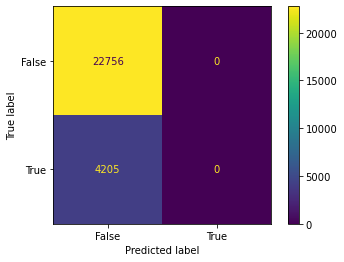

In [54]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

booster = HistGradientBoostingClassifier(max_iter=2)

X_ready = preproc_pipe.fit_transform(X_train).toarray() # toarray to deal with sparse error
booster.fit(X_ready,y_train)

plot_confusion_matrix(booster, preproc_pipe.transform(X_test).toarray(), y_test, normalize=None) # normalize='all' {'true', 'pred', 'all'}
plt.show()

# imbalanced data... or another problem? For Wednesday!


In [36]:
## fix for Wed: this leads to TypeError: A sparse matrix was passed, but dense data is required.
# boosting_pipe = make_pipeline(preproc_pipe, booster)
# cross_validate(boosting_pipe,X_train,y_train,
#                scoring='precision_micro',
#                cv=2)['test_score'].mean()  

## Homework review and demos

Let's review the assignment. 

Any volunteers?
